# 华东师范大学学科画像探索性分析

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import glob

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [7]:
# 读取所有学科数据文件
csv_dir = Path('csv')
csv_files = sorted([f for f in csv_dir.glob('*.csv') if f.name != '0-ALL.csv'])

print(f"共找到 {len(csv_files)} 个学科文件")

# 按照名称开头的数字排序，与学科一一对应
import re
def extract_prefix_num(f):
    m = re.match(r"(\d+)-", f.name)
    return int(m.group(1)) if m else float('inf')

csv_files = sorted(csv_files, key=extract_prefix_num)


共找到 22 个学科文件


## 获取华东师范大学每一个学科的排名

In [8]:
institution_name = "EAST CHINA NORMAL UNIVERSITY"

subject_names = []
subject_ranks = []
rank_inverteds = []
subject_max_ranks = []

for csv_file in csv_files:
    subject = csv_file.stem.split('-', 1)[1]
    df = pd.read_csv(csv_file, skiprows=1, encoding='latin1')
    df.columns = df.columns.str.strip()
    df_valid = df[df['Institutions'].notna()].copy()
    df_valid = df_valid[~df_valid['Institutions'].str.contains('Copyright|Clarivate', na=False)]
    max_rank = len(df_valid)
    subject_names.append(subject)
    subject_max_ranks.append(max_rank)
    found = df_valid[df_valid['Institutions'].str.strip().str.upper() == institution_name]
    if found.empty:
        subject_ranks.append(np.nan)
        rank_inverteds.append(0)
    else:
        rank = found.index[0] - df_valid.index[0] + 1 # 行号转为排名（1-base）
        subject_ranks.append(rank)
        # 为雷达图反向映射，排名越靠前，值越大。为简单，这里用“倒数比例”：最大排名 - 当前排名 + 1
        rank_inverteds.append(max_rank - rank + 1)

rank_df = pd.DataFrame({
    'Subject': subject_names,
    'Rank': ['/' if pd.isna(r) else int(r) for r in subject_ranks]
})
display(rank_df)

,Subject,Rank
0,Agricultural Sciences,845
1,Biology & Biochemistry,721
2,Chemistry,90
3,Clinical Medicine,2852
4,Computer Science,207
5,Economics & Business,/
6,Engineering,317
7,Environment Ecology,130
8,Geosciences,275
9,Immunology,/


## 学科雷达图

未上榜学科： Economics & Business, Immunology, Microbiology, Multidisciplinary, Space Science


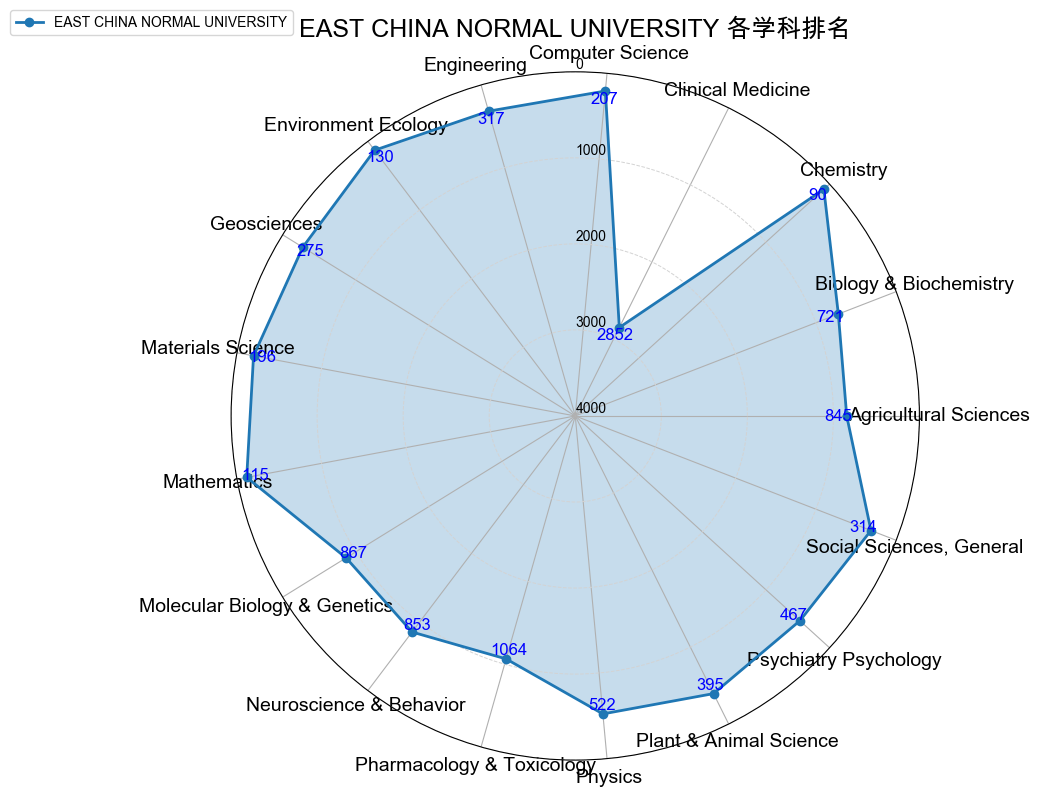

In [9]:
# 绘制雷达图：只显示有排名的学科，未排名的学科不显示

# 过滤有排名的学科
labels = [subject_names[i] for i, r in enumerate(subject_ranks) if not pd.isna(r)]
ranks = [int(r) if int(r) <= 9990 else 9990 for r in subject_ranks if not pd.isna(r)]

# 打印未上榜学科
not_ranked_subjects = [subject_names[i] for i, r in enumerate(subject_ranks) if pd.isna(r)]
if not_ranked_subjects:
    print("未上榜学科：", ", ".join(not_ranked_subjects))

labels_radar = labels + [labels[0]]
ranks_radar = ranks + [ranks[0]]
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars + 1, endpoint=True)
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, ranks_radar, 'o-', linewidth=2, label=institution_name)
ax.fill(angles, ranks_radar, alpha=0.25)
for i, (angle, rank) in enumerate(zip(angles[:-1], ranks)):
    ax.text(angle, rank + 100, str(rank), ha='center', va='center', fontsize=12, color='blue')  # rank + 100用于稍微偏离点避免遮挡
ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels, fontsize=14)
# 设置标题和半径轴信息
ax.set_title(f"{institution_name} 各学科排名", fontsize = 18)
ax.set_rlim(4000.5, 0)
ax.set_rlabel_position(90)
# 设置极坐标的数字标签范围
ax.set_yticks([0, 1000, 2000, 3000, 4000])
ax.set_yticklabels([str(v) for v in [0,1000,2000,3000,4000]])
ax.yaxis.grid(True, color='lightgray', linestyle='--', linewidth=0.7)

plt.legend(loc='best', bbox_to_anchor=(0.1, 1.1))
plt.tight_layout()
plt.show()


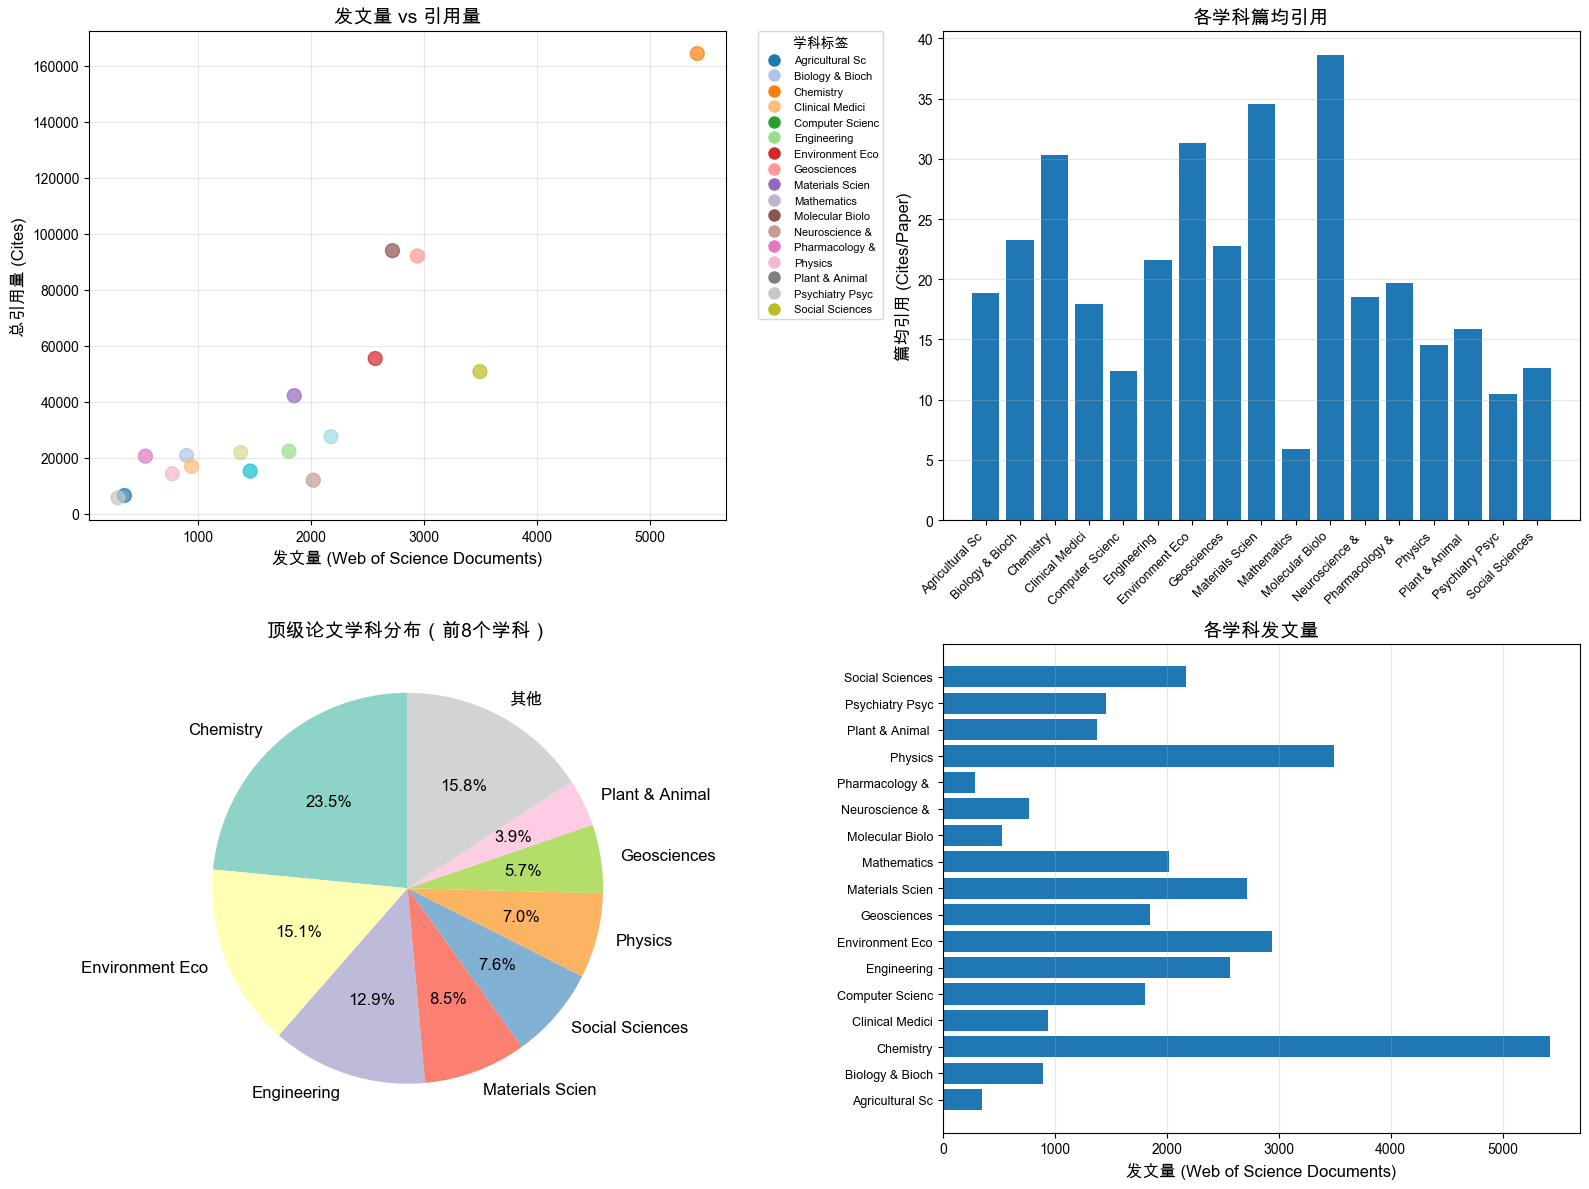

In [24]:
csv_folder = 'csv'
all_data = []

# 读取学科文件
for i in range(1, 23):
    pattern = os.path.join(csv_folder, f'{i}-*.csv')
    files = glob.glob(pattern)
    if files:
        df = pd.read_csv(files[0], encoding='latin1')
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # 去掉多余的列
        if not any(col in df.columns for col in ['Institutions', '机构', '院校']):
            df = pd.read_csv(files[0], encoding='latin1', header=1)
            df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df['Subject'] = os.path.basename(files[0]).split('-', 1)[-1].replace('.csv', '').strip()  # 增加学科信息
        all_data.append(df)

# 合并
df_all = pd.concat(all_data, ignore_index=True)

# 数据清洗
df_clean = df_all.copy()

ecnu_name_variants = [
    'East China Normal University'
]

# 提取华师大在各学科的数据
ecnu_subject_data = df_clean[df_clean['Institutions'].astype(str).str.contains('|'.join(ecnu_name_variants), case=False, na=False)]

plt.figure(figsize=(16, 12))

# 子图1: 发文量vs引用量散点图
plt.subplot(2, 2, 1)
x_vals = pd.to_numeric(ecnu_subject_data['Web of Science Documents'], errors='coerce')
y_vals = pd.to_numeric(ecnu_subject_data['Cites'], errors='coerce')

num_subjects = len(ecnu_subject_data)
if num_subjects <= 20:
    colors = plt.get_cmap('tab20').colors[:num_subjects]
else:
    color_map = plt.get_cmap('tab20')
    colors = [color_map(i % 20) for i in range(num_subjects)]
scatter = plt.scatter(
    x_vals,
    y_vals,
    s=100, alpha=0.7, c=range(num_subjects), cmap='tab20', label=None
)
plt.xlabel('发文量 (Web of Science Documents)', fontsize=12)
plt.ylabel('总引用量 (Cites)', fontsize=12)
plt.title('发文量 vs 引用量', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
# 图例
subject_labels = []
for i, row in ecnu_subject_data.iterrows():
    subject_name = row['Subject'] if 'Subject' in row else ""
    if pd.notnull(subject_name) and '-' in str(subject_name):
        subject_name = str(subject_name).split('-', 1)[1]
    subject_labels.append(str(subject_name)[:15])
# 标注用于图例的handle
handles = []
for i, (x, y, label) in enumerate(zip(x_vals, y_vals, subject_labels)):
    handles.append(plt.Line2D(
        [], [], marker='o', color='w',
        markerfacecolor=colors[i % len(colors)],
        markersize=10, label=label
    ))
plt.legend(handles=handles, title="学科标签", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=10, borderaxespad=0.)


# 子图2: 篇均引用分布
plt.subplot(2, 2, 2)
subject_names = []
for s in ecnu_subject_data['Subject']:
    if pd.notnull(s) and '-' in str(s):
        subject_names.append(str(s).split('-', 1)[1][:15])
    else:
        subject_names.append(str(s)[:15])
if 'Cites/Paper' in ecnu_subject_data.columns:
    plt.bar(range(len(ecnu_subject_data)), pd.to_numeric(ecnu_subject_data['Cites/Paper'], errors='coerce'))
    plt.xticks(range(len(ecnu_subject_data)), subject_names, rotation=45, ha='right', fontsize=9)
    plt.title('各学科篇均引用', fontsize=14, fontweight='bold')
    plt.ylabel('篇均引用 (Cites/Paper)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
else:
    plt.text(0.5, 0.5, '无篇均引用数据', ha='center', va='center', fontsize=12)
    plt.title('各学科篇均引用', fontsize=14, fontweight='bold')

# 子图3: 顶级论文数量 - 只显示前6个学科，其余归为"其他"
plt.subplot(2, 2, 3)
top_papers_data = pd.DataFrame({
    'Subject': subject_names,
    'Top_Papers': pd.to_numeric(ecnu_subject_data['Top Papers'], errors='coerce')
}).sort_values('Top_Papers', ascending=False)
# 只显示前8个学科
top_8 = top_papers_data.iloc[:8]
others_data = top_papers_data.iloc[8:]
pie_data = list(top_8['Top_Papers'])
pie_labels = list(top_8['Subject'])
# 添加"其他"类别
if len(others_data) > 0:
    others_sum = others_data['Top_Papers'].sum()
    pie_data.append(others_sum)
    pie_labels.append('其他')
    colors = list(plt.cm.Set3(range(8))) + ['lightgray']
else:
    colors = list(plt.cm.Set3(range(8)))
wedges, texts, autotexts = plt.pie(
    pie_data,
    labels=pie_labels,
    autopct='%1.1f%%', 
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title('顶级论文学科分布（前8个学科）', fontsize=14, fontweight='bold')

# 子图4: 发文量分布
plt.subplot(2, 2, 4)
plt.barh(
    range(len(ecnu_subject_data)),
    pd.to_numeric(ecnu_subject_data['Web of Science Documents'], errors='coerce')
)
plt.yticks(range(len(ecnu_subject_data)), subject_names, fontsize=9)
plt.xlabel('发文量 (Web of Science Documents)', fontsize=12)
plt.title('各学科发文量', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 优势学科识别


In [11]:
# 评分权重参数
weight_docs = 0.3
weight_cites = 0.3
weight_top_papers = 0.4

# 打印评分规则
print("评分规则如下：")
print(f"  综合得分 = 发文量归一化 * {weight_docs} + 引用量归一化 * {weight_cites} + 顶级论文数归一化 * {weight_top_papers}")

ecnu_with_score = ecnu_subject_data.copy()

def safe_max(series):
    numerics = pd.to_numeric(series, errors='coerce')
    valid_vals = numerics[~numerics.isnull()]
    return valid_vals.max() if not valid_vals.empty else 1

# 三项最大值阈值
max_docs = safe_max(ecnu_with_score['Web of Science Documents']) if 'Web of Science Documents' in ecnu_with_score.columns else 1
max_cites = safe_max(ecnu_with_score['Cites']) if 'Cites' in ecnu_with_score.columns else 1
max_top_papers = safe_max(ecnu_with_score['Top Papers']) if 'Top Papers' in ecnu_with_score.columns else 1

# 归一化得分
ecnu_with_score['Docs_Score'] = (
    pd.to_numeric(ecnu_with_score['Web of Science Documents'], errors='coerce') / max_docs
    if 'Web of Science Documents' in ecnu_with_score.columns else 0
)
ecnu_with_score['Cites_Score'] = (
    pd.to_numeric(ecnu_with_score['Cites'], errors='coerce') / max_cites
    if 'Cites' in ecnu_with_score.columns else 0
)
ecnu_with_score['Top_Papers_Score'] = (
    pd.to_numeric(ecnu_with_score['Top Papers'], errors='coerce') / max_top_papers
    if 'Top Papers' in ecnu_with_score.columns else 0
)
ecnu_with_score['Composite_Score'] = (
    ecnu_with_score['Docs_Score'] * weight_docs +
    ecnu_with_score['Cites_Score'] * weight_cites +
    ecnu_with_score['Top_Papers_Score'] * weight_top_papers
)

from IPython.display import display

# 输出评分DataFrame
score_cols = [
    'Subject', 
    'Docs_Score',
    'Cites_Score',
    'Top_Papers_Score',
    'Composite_Score'
]
score_df = ecnu_with_score[score_cols] if all(col in ecnu_with_score.columns for col in score_cols) else ecnu_with_score

# 保留3位小数
score_df = score_df.copy()
for col in ['Docs_Score', 'Cites_Score', 'Top_Papers_Score', 'Composite_Score']:
    if col in score_df.columns:
        score_df[col] = score_df[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else x)

print("\n各学科详细评分: ")
display(score_df.sort_values("Composite_Score", ascending=False).reset_index(drop=True))

评分规则如下：
  综合得分 = 发文量归一化 * 0.3 + 引用量归一化 * 0.3 + 顶级论文数归一化 * 0.4

各学科详细评分: 


,Subject,Docs_Score,Cites_Score,Top_Papers_Score,Composite_Score
0,Chemistry,1.000,1.000,1.000,1.000
1,Environment Ecology,0.543,0.560,0.643,0.588
2,Materials Science,0.502,0.572,0.363,0.467
3,Engineering,0.474,0.337,0.548,0.462
4,Physics,0.645,0.309,0.299,0.406
5,"Social Sciences, General",0.401,0.167,0.325,0.301
6,Geosciences,0.341,0.256,0.242,0.276
7,Computer Science,0.333,0.136,0.159,0.204
8,Mathematics,0.373,0.073,0.140,0.190
9,Plant & Animal Science,0.254,0.133,0.166,0.182
